In [ ]:
from gliomi import *

In [ ]:
def get_slice_indexes(sequence_repo, subject, percentile, interval):
    
    roi = sequence_repo.get_roi(subject)

    ((rmin, rmax), (cmin, cmax), (zmin, zmax)) = get_bounding_box(roi)

    width = rmax - rmin
    height = cmax - cmin
    z_height = zmax - zmin

    roi_sizes = get_roi_size(roi, 2)
    
    return {'r-axis': (rmin, rmax), 'c-axis': (cmin, cmax), 'z-axis': (zmin, zmax), 'sizes': roi_sizes}

In [ ]:
def get_index_list_task(item):
    sequence_repo, subject, percentile, interval = item
    print("Working on:", subject)
    result = get_slice_indexes(sequence_repo, subject, percentile, interval)
    print(subject, ":", result)
    return result

In [ ]:
%%time

import glob
import os
import multiprocessing

from multiprocessing import Pool

sequence_repo = SequenceRepoGliomi("/data/RMN/dataset-gliomi")

items = []
for file in glob.glob("/data/RMN/dataset-gliomi/scaled/*"):
    subject = os.path.basename(file)
    items.append([sequence_repo, subject, 0, 10])
    
print("Starting...")
    
processing_pool = Pool(int(multiprocessing.cpu_count()))
res = processing_pool.map(get_index_list_task, items)
print(res)

In [ ]:
final = {}
for i, item in enumerate(items):
    sequence_repo, subject, percentile, interval = item
    final[subject] = res[i]

In [ ]:
import pickle

with open("/data/RMN/dataset-gliomi-cnn/roi-metadata.pickle", "wb") as file:
    pickle.dump(final, file)

In [ ]:
ls -lh /data/RMN/dataset-gliomi-cnn/roi-metadata.pickle

In [ ]:
with open("/data/RMN/dataset-gliomi-cnn/roi-metadata.pickle", "rb") as file:
    print(pickle.load(file))

In [ ]:
# Extract sequence from roi bounding box

"""
Get the part of sequence masked and related to its bounding box
"""
def mask_and_crop(sequence, affine, bbox, full_brain=False):
    
    ((rmin, rmax), (cmin, cmax), (zmin, zmax)) = bbox
    
    if full_brain:
        rmin, rmax = 0, sequence.shape[0]
        cmin, cmax = 0, sequence.shape[1]

    delta_r = rmax-rmin
    delta_c = cmax-cmin
    delta_z = zmax-zmin
    
    data = sequence.get_fdata()[rmin:(rmin+delta_r),cmin:(cmin+delta_c),zmin:(zmin+delta_z)]

    return data, affine

"""
Extract mask from a sequence and resize to a cube a a given side
"""
def mask_crop_resize(sequence, affine, bbox, side, full_brain=False):

    data, affine = mask_and_crop(sequence, affine, bbox, full_brain)
    
    ((rmin, rmax), (cmin, cmax), (zmin, zmax)) = bbox

    if full_brain:
        rmin, rmax = 0, sequence.shape[0]
        cmin, cmax = 0, sequence.shape[1]

    (dim1, dim2, dim3) = (rmax - rmin), (cmax - cmin), (zmax - zmin)

    scale_affine = np.array([[float(side) / dim1, 0, 0, 0], 
                             [0, float(side) / dim2, 0, 0], 
                             [0, 0, float(zmax - zmin) / dim3, 0], 
                             [0, 0, 0, 1]])
    
    resampled_roi = nb.Nifti1Image(
        data,
        affine=scale_affine)

    img = nilearn.image.resample_img(
        resampled_roi, 
        target_affine=np.eye(4),
        target_shape=(side, side, zmax - zmin), 
        interpolation='nearest')
    
    return img.get_fdata(), img.affine


In [ ]:
who = "ALESSANDRINI_GLAUCO" # "ANGELONI_GIUSEPPINA" 

In [ ]:
roi = sequence_repo.get_roi(who) #, "FLAIR")
sequence = sequence_repo.get_sequence(who, "T1")

sequence = nb.Nifti1Image(
        sequence.get_fdata() * roi.get_fdata(),
        affine=sequence.affine)

In [ ]:
bbox = final[who]['r-axis'], final[who]['c-axis'], final[who]['z-axis']

In [ ]:
bbox

In [ ]:
bbox = (bbox[0], bbox[1], (0, sequence.shape[2]))

In [ ]:
i, a = mask_crop_resize(sequence, sequence.affine, bbox, 224, full_brain=False)

In [ ]:
i.shape, a.shape

In [ ]:
rows = int(i.shape[2] / 4) + 1

fig = plt.figure(figsize=(40., rows * 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, img in zip(grid, [i[:,:,j] for j in range(i.shape[2])]):
    ax.imshow(img)
    # draw_text_in_dataset(ax, label)

plt.show()


In [ ]:
v = sequence.get_fdata()

np.min(v), np.max(v), np.mean(v), np.std(v)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

sns.distplot(v[v > 0].flatten());

# Exploration

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

def plot_distribution_values_in_roi(ax, subject, sequence_name, side, title):
    
    roi = sequence_repo.get_roi(subject)
    
    sequence = sequence_repo.get_sequence(subject, sequence_name)

    sequence = nb.Nifti1Image(
            sequence.get_fdata() * roi.get_fdata(),
            affine=sequence.affine)
    
    # bbox = final[subject]['r-axis'], final[subject]['c-axis'], final[subject]['z-axis']
    
    # i, _ = mask_crop_resize(sequence, sequence.affine, bbox, side, full_brain=False)
    
    v = sequence.get_fdata()
    
    v = v[v > 0]
    
    _max = np.max(v)
    _min = np.min(v)
    v = (v - _min) / (_max - _min)
    
    print(subject, np.histogram(v))

    sns.distplot(v, ax=ax, label=title, kde_kws={"label": f"{subject}-{title}"});

In [ ]:
df = pd.read_csv("/data/RMN/dataset-gliomi-cnn/dataset-survivor.csv")
subjects = np.array(df.iloc[:,1])
labels = np.array(df.iloc[:,2])
for subject, label in zip(subjects, labels):
    print(subject, ",", label)

In [ ]:
from matplotlib import pyplot
import seaborn

a4_dims = (11.7, 8.27)

fig, ax = pyplot.subplots(figsize=a4_dims)

plot_distribution_values_in_roi(ax, "BIANCHI_GIOVANNI", "FLAIR", 224, f"0")
plot_distribution_values_in_roi(ax, "BIAVATI_S", "FLAIR", 224, f"0")
plot_distribution_values_in_roi(ax, "BIANCHI_ORAZIO", "FLAIR", 224, f"0")

plot_distribution_values_in_roi(ax, "BOEZI_MARIO", "FLAIR", 224, f"1")
plot_distribution_values_in_roi(ax, "CAMPLESE_CANDEROLA", "FLAIR", 224, f"1")
plot_distribution_values_in_roi(ax, "CACACE_PAOLO", "FLAIR", 224, f"1")

# Simple SVM classifier

In [12]:
%%time

import pandas as pd
import numpy as np
from gliomi import *

import multiprocessing

from multiprocessing import Pool

sequence_repo = SequenceRepoGliomi("/data/RMN/dataset-gliomi")

# Load data

def get_histogram(item):
    
    sequence_repo, subject, sequence_names, label = item

    print("Working on", subject)

    roi = sequence_repo.get_roi(subject)
    
    histograms = []
    
    for sequence_name in sequence_names:
    
        sequence = sequence_repo.get_sequence(subject, sequence_name)

        sequence = nb.Nifti1Image(
                sequence.get_fdata() * roi.get_fdata(),
                affine=sequence.affine)

        values = sequence.get_fdata()

        values = values[values > 0]

        _max = np.max(values)
        _min = np.min(values)
        
        values = (values - _min) / (_max - _min)
    
        histograms.append(np.histogram(values))
        
    return histograms, label

df = pd.read_csv("/data/RMN/dataset-gliomi-cnn/dataset-survivor.csv")
subjects = np.array(df.iloc[:,1])
labels = np.array(df.iloc[:,2])

tasks = []

sequence_names = ["T1", "MPRAGE", "FLAIR"]

real_names = []
for subject, label in zip(subjects, labels):
    if subject == "RE_ATTILIO":
        continue
    if not sequence_repo.has(subject, "FLAIR"):
        continue
    if not sequence_repo.has(subject, "MPRAGE"):
        continue
    if not sequence_repo.has(subject, "T1"):
        continue
    tasks.append((sequence_repo, subject, sequence_names, label))
    real_names.append(subject)
    
print("Starting on", len(tasks), "tasks")
    
processing_pool = Pool(int(multiprocessing.cpu_count()))
dataset = processing_pool.map(get_histogram, tasks)
print(dataset)

Starting on 130 tasks
Working on ALESSANDRINI_GLAUCO
Working on BAGNOLI_VINCENZO
Working on BATTISTA_DOMENICA
Working on ASSANTO_MARIA
Working on BARONTINI_MARIA_GIOVANNA
Working on BERNOLA_TERESA
Working on ANGELONI_GIUSEPPINA
Working on BERGNACH_SILVANO
Working on BEVILACQUA_RITA
Working on BERTUZZI_LUISA
Working on BIANCHI_GIOVANNI
Working on BIANCHI_ORAZIO
Working on BIAVATI_S
Working on BOVE_A
Working on BOEZI_MARIO
Working on CACACE_PAOLO
Working on CALDARONI_ANNA
Working on COLAZZO_LUIGI_GIUSEPPE
Working on COSTANZI_P
Working on CAMACCI_FILIBERTO
Working on CARZEDDA_PAOLO
Working on DEL_BOVE_PIERINA
Working on DI_MARCO_L
Working on DI_LORENZO_TOMMASO
Working on DIASPRO_G
Working on CIMPUREANU_N
Working on CATALANI_F
Working on DI_MASO_SIMONE
Working on CARULLI_L
Working on CAMPLESE_CANDEROLA
Working on COLAFRANCESCO_ROCCO
Working on DI_CARLATONIO_MAURIZIO
Working on DE_SANTIS_GIORGO
Working on CAPEZZONE
Working on CRESCENZI_ARMANDO
Working on DOBRISAN_DORINA
Working on D_ANGELI_

Process ForkPoolWorker-117:
Process ForkPoolWorker-109:
Process ForkPoolWorker-114:
Process ForkPoolWorker-93:
Process ForkPoolWorker-113:
Process ForkPoolWorker-90:
Process ForkPoolWorker-86:
Process ForkPoolWorker-106:
Process ForkPoolWorker-104:
Process ForkPoolWorker-119:
Process ForkPoolWorker-112:
Process ForkPoolWorker-116:
Process ForkPoolWorker-89:
Process ForkPoolWorker-102:
Process ForkPoolWorker-96:
Process ForkPoolWorker-111:
Process ForkPoolWorker-88:
Process ForkPoolWorker-97:
Process ForkPoolWorker-95:
Process ForkPoolWorker-85:
Process ForkPoolWorker-87:
Process ForkPoolWorker-98:
Process ForkPoolWorker-107:
Process ForkPoolWorker-105:
Process ForkPoolWorker-82:
Process ForkPoolWorker-103:
Process ForkPoolWorker-81:
Traceback (most recent call last):
Process ForkPoolWorker-92:
Traceback (most recent call last):
Process ForkPoolWorker-83:
Process ForkPoolWorker-94:
Process ForkPoolWorker-108:
Process ForkPoolWorker-101:
Process ForkPoolWorker-118:
Traceback (most recent

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kw

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  Fi

In [13]:
dataset

[([(array([  221,  8721, 31528, 32102,  5993,   528,    11,    14,    13,
               8]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
   (array([  171, 26534, 37820,  4727,  2677,  2475,  2575,  1731,   403,
              26]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
   (array([   45,   159,   487, 12526, 12971, 18499, 22060, 11535,   766,
              91]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))],
  0.0),
 ([(array([  181,  2958, 11374, 12278,  7385,  3772,    99,    43,    11,
              13]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
   (array([  733, 10268, 12755,  6299,  6610,   840,   379,   157,    54,
              19]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
   (array([ 604, 2993, 6189, 9761, 9043, 8025, 1435,   34,   21,    9]),
    array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))],
  1.0),
 ([(array([  258,  4681, 

In [16]:
dataset[0][0]

[(array([  221,  8721, 31528, 32102,  5993,   528,    11,    14,    13,
             8]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
 (array([  171, 26534, 37820,  4727,  2677,  2475,  2575,  1731,   403,
            26]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])),
 (array([   45,   159,   487, 12526, 12971, 18499, 22060, 11535,   766,
            91]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))]

In [18]:
histograms = []
y = []
for item in dataset:
    h = []
    for histogram in item[0]:
        h.extend(histogram[0])
    histograms.append(h)
    y.append(item[1])

In [19]:
len(histograms)

130

In [20]:
len(histograms[0])

30

In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split

scores = []

for random_state in range(50):
    
    X_train, X_test, y_train, y_test = train_test_split(histograms, y, test_size=0.2, random_state=random_state)

    clf = svm.SVC()

    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    
    scores.append(score)

    print(random_state, ":", score)
    
scores = np.array(scores)

print(np.mean(scores), np.std(scores))

0 : 0.6153846153846154
1 : 0.4230769230769231
2 : 0.46153846153846156
3 : 0.5384615384615384
4 : 0.6153846153846154
5 : 0.5
6 : 0.5
7 : 0.5
8 : 0.5384615384615384
9 : 0.6153846153846154
10 : 0.46153846153846156
11 : 0.6153846153846154
12 : 0.38461538461538464
13 : 0.5
14 : 0.5769230769230769
15 : 0.5769230769230769
16 : 0.5769230769230769
17 : 0.5769230769230769
18 : 0.5769230769230769
19 : 0.5384615384615384
20 : 0.4230769230769231
21 : 0.46153846153846156
22 : 0.5384615384615384
23 : 0.5
24 : 0.5769230769230769
25 : 0.38461538461538464
26 : 0.5
27 : 0.5
28 : 0.5384615384615384
29 : 0.4230769230769231
30 : 0.7307692307692307
31 : 0.5384615384615384
32 : 0.5
33 : 0.4230769230769231
34 : 0.4230769230769231
35 : 0.46153846153846156
36 : 0.5
37 : 0.5384615384615384
38 : 0.5384615384615384
39 : 0.38461538461538464
40 : 0.5769230769230769
41 : 0.5384615384615384
42 : 0.5384615384615384
43 : 0.5384615384615384
44 : 0.6538461538461539
45 : 0.5
46 : 0.5384615384615384
47 : 0.5384615384615384
4

In [65]:
from sklearn.preprocessing import StandardScaler

h = np.array(histograms)

scaler = StandardScaler()

X = scaler.fit_transform(h)

In [105]:
np.min(X), np.max(X), np.mean(X), np.std(X)

(-0.7302965022981943, 10.193821336724634, 0.0, 1.0)

In [106]:
y

[0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [112]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.utils import to_categorical

model = Sequential()
model.add(Dense(20, input_dim=30, activation="relu", kernel_initializer="uniform"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="relu", kernel_initializer="uniform"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax", kernel_initializer="uniform"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=8)

Train on 104 samples, validate on 26 samples
Epoch 1/1000
104/104 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/1000
104/104 [==============================] - 0s 984us/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4615 - val_loss: 0.6930 - val_accuracy: 0.5385
Epoch 4/1000
104/104 [==============================] - 0s 987us/step - loss: 0.6934 - accuracy: 0.4327 - val_loss: 0.6929 - val_accuracy: 0.5385
Epoch 5/1000
104/104 [==============================] - 0s 992us/step - loss: 0.6933 - accuracy: 0.5096 - val_loss: 0.6928 - val_accuracy: 0.5385
Epoch 6/1000
104/104 [==============================] - 0s 978us/step - loss: 0.6933 - accuracy: 0.5096 - val_loss: 0.6927 - val_accuracy: 0.5385
Epoch 7/1000
104/104 [==============================] - 0s 952us/step - loss: 0.693

104/104 [==============================] - 0s 860us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6919 - val_accuracy: 0.5385
Epoch 57/1000
104/104 [==============================] - 0s 992us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6918 - val_accuracy: 0.5385
Epoch 58/1000
104/104 [==============================] - 0s 978us/step - loss: 0.6933 - accuracy: 0.5096 - val_loss: 0.6919 - val_accuracy: 0.5385
Epoch 59/1000
104/104 [==============================] - 0s 926us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6918 - val_accuracy: 0.5385
Epoch 60/1000
104/104 [==============================] - 0s 925us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6918 - val_accuracy: 0.5385
Epoch 61/1000
104/104 [==============================] - 0s 944us/step - loss: 0.6930 - accuracy: 0.5096 - val_loss: 0.6918 - val_accuracy: 0.5385
Epoch 62/1000
104/104 [==============================] - 0s 960us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6918 - val_ac

Epoch 112/1000
104/104 [==============================] - 0s 924us/step - loss: 0.6930 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 113/1000
104/104 [==============================] - 0s 859us/step - loss: 0.6930 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 114/1000
104/104 [==============================] - 0s 858us/step - loss: 0.6933 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 115/1000
104/104 [==============================] - 0s 769us/step - loss: 0.6930 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 116/1000
104/104 [==============================] - 0s 808us/step - loss: 0.6929 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 117/1000
104/104 [==============================] - 0s 860us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6917 - val_accuracy: 0.5385
Epoch 118/1000
104/104 [==============================] - 0s 831us/step - loss: 0.6930 - accuracy: 0.5096 - val_

104/104 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5096 - val_loss: 0.6916 - val_accuracy: 0.5385
Epoch 168/1000
104/104 [==============================] - 0s 865us/step - loss: 0.6927 - accuracy: 0.5096 - val_loss: 0.6916 - val_accuracy: 0.5385
Epoch 169/1000
104/104 [==============================] - 0s 893us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6916 - val_accuracy: 0.5385
Epoch 170/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5096 - val_loss: 0.6915 - val_accuracy: 0.5385
Epoch 171/1000
104/104 [==============================] - 0s 954us/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6916 - val_accuracy: 0.5385
Epoch 172/1000
104/104 [==============================] - 0s 907us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6915 - val_accuracy: 0.5385
Epoch 173/1000
104/104 [==============================] - 0s 808us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6915 - val_

104/104 [==============================] - 0s 992us/step - loss: 0.6928 - accuracy: 0.5096 - val_loss: 0.6914 - val_accuracy: 0.5385
Epoch 223/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5096 - val_loss: 0.6914 - val_accuracy: 0.5385
Epoch 224/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5096 - val_loss: 0.6914 - val_accuracy: 0.5385
Epoch 225/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5096 - val_loss: 0.6913 - val_accuracy: 0.5385
Epoch 226/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5096 - val_loss: 0.6913 - val_accuracy: 0.5385
Epoch 227/1000
104/104 [==============================] - 0s 974us/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6913 - val_accuracy: 0.5385
Epoch 228/1000
104/104 [==============================] - 0s 994us/step - loss: 0.6927 - accuracy: 0.5096 - val_loss: 0.6913 - val_accu

104/104 [==============================] - 0s 532us/step - loss: 0.6916 - accuracy: 0.5096 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 278/1000
104/104 [==============================] - 0s 517us/step - loss: 0.6923 - accuracy: 0.5096 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 279/1000
104/104 [==============================] - 0s 553us/step - loss: 0.6921 - accuracy: 0.5096 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 280/1000
104/104 [==============================] - 0s 555us/step - loss: 0.6911 - accuracy: 0.5096 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 281/1000
104/104 [==============================] - 0s 555us/step - loss: 0.6902 - accuracy: 0.5096 - val_loss: 0.6908 - val_accuracy: 0.5385
Epoch 282/1000
104/104 [==============================] - 0s 483us/step - loss: 0.6918 - accuracy: 0.5096 - val_loss: 0.6907 - val_accuracy: 0.5385
Epoch 283/1000
104/104 [==============================] - 0s 538us/step - loss: 0.6909 - accuracy: 0.5096 - val_loss: 0.6907 - 

104/104 [==============================] - 0s 576us/step - loss: 0.6853 - accuracy: 0.5192 - val_loss: 0.6887 - val_accuracy: 0.5385
Epoch 333/1000
104/104 [==============================] - 0s 556us/step - loss: 0.6905 - accuracy: 0.5096 - val_loss: 0.6886 - val_accuracy: 0.5385
Epoch 334/1000
104/104 [==============================] - 0s 606us/step - loss: 0.6897 - accuracy: 0.5096 - val_loss: 0.6886 - val_accuracy: 0.5385
Epoch 335/1000
104/104 [==============================] - 0s 588us/step - loss: 0.6867 - accuracy: 0.5096 - val_loss: 0.6886 - val_accuracy: 0.5385
Epoch 336/1000
104/104 [==============================] - 0s 667us/step - loss: 0.6878 - accuracy: 0.5192 - val_loss: 0.6885 - val_accuracy: 0.5385
Epoch 337/1000
104/104 [==============================] - 0s 559us/step - loss: 0.6895 - accuracy: 0.5096 - val_loss: 0.6885 - val_accuracy: 0.5385
Epoch 338/1000
104/104 [==============================] - 0s 545us/step - loss: 0.6876 - accuracy: 0.5096 - val_loss: 0.6884 - 

104/104 [==============================] - 0s 545us/step - loss: 0.6827 - accuracy: 0.5481 - val_loss: 0.6839 - val_accuracy: 0.4231
Epoch 388/1000
104/104 [==============================] - 0s 449us/step - loss: 0.6797 - accuracy: 0.4808 - val_loss: 0.6834 - val_accuracy: 0.3462
Epoch 389/1000
104/104 [==============================] - 0s 464us/step - loss: 0.6884 - accuracy: 0.4519 - val_loss: 0.6836 - val_accuracy: 0.3846
Epoch 390/1000
104/104 [==============================] - 0s 563us/step - loss: 0.6832 - accuracy: 0.5288 - val_loss: 0.6835 - val_accuracy: 0.4231
Epoch 391/1000
104/104 [==============================] - 0s 537us/step - loss: 0.6785 - accuracy: 0.5577 - val_loss: 0.6835 - val_accuracy: 0.4231
Epoch 392/1000
104/104 [==============================] - 0s 591us/step - loss: 0.6792 - accuracy: 0.5673 - val_loss: 0.6831 - val_accuracy: 0.4231
Epoch 393/1000
104/104 [==============================] - 0s 559us/step - loss: 0.6768 - accuracy: 0.5865 - val_loss: 0.6829 - 

104/104 [==============================] - 0s 1ms/step - loss: 0.6588 - accuracy: 0.5577 - val_loss: 0.6814 - val_accuracy: 0.4615
Epoch 443/1000
104/104 [==============================] - 0s 990us/step - loss: 0.6678 - accuracy: 0.5673 - val_loss: 0.6809 - val_accuracy: 0.4615
Epoch 444/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6617 - accuracy: 0.6250 - val_loss: 0.6815 - val_accuracy: 0.4615
Epoch 445/1000
104/104 [==============================] - 0s 964us/step - loss: 0.6593 - accuracy: 0.5673 - val_loss: 0.6815 - val_accuracy: 0.4615
Epoch 446/1000
104/104 [==============================] - 0s 993us/step - loss: 0.6628 - accuracy: 0.5673 - val_loss: 0.6818 - val_accuracy: 0.4615
Epoch 447/1000
104/104 [==============================] - 0s 967us/step - loss: 0.6605 - accuracy: 0.6154 - val_loss: 0.6814 - val_accuracy: 0.5000
Epoch 448/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.5481 - val_loss: 0.6820 - val_ac

Epoch 498/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6323 - accuracy: 0.6442 - val_loss: 0.6984 - val_accuracy: 0.4231
Epoch 499/1000
104/104 [==============================] - 0s 983us/step - loss: 0.6529 - accuracy: 0.5865 - val_loss: 0.6979 - val_accuracy: 0.4231
Epoch 500/1000
104/104 [==============================] - 0s 999us/step - loss: 0.6723 - accuracy: 0.6250 - val_loss: 0.6974 - val_accuracy: 0.4231
Epoch 501/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6731 - val_loss: 0.6954 - val_accuracy: 0.4231
Epoch 502/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6411 - accuracy: 0.6538 - val_loss: 0.6959 - val_accuracy: 0.4231
Epoch 503/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6563 - accuracy: 0.5577 - val_loss: 0.6971 - val_accuracy: 0.4231
Epoch 504/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6513 - accuracy: 0.5577 - val_loss: 0.69

104/104 [==============================] - 0s 935us/step - loss: 0.6224 - accuracy: 0.6538 - val_loss: 0.7181 - val_accuracy: 0.3846
Epoch 554/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.6058 - val_loss: 0.7184 - val_accuracy: 0.3846
Epoch 555/1000
104/104 [==============================] - 0s 999us/step - loss: 0.6001 - accuracy: 0.7115 - val_loss: 0.7199 - val_accuracy: 0.3846
Epoch 556/1000
104/104 [==============================] - 0s 982us/step - loss: 0.6363 - accuracy: 0.6250 - val_loss: 0.7220 - val_accuracy: 0.3846
Epoch 557/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6438 - accuracy: 0.6635 - val_loss: 0.7237 - val_accuracy: 0.3846
Epoch 558/1000
104/104 [==============================] - 0s 975us/step - loss: 0.6325 - accuracy: 0.6538 - val_loss: 0.7235 - val_accuracy: 0.3846
Epoch 559/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.6340 - accuracy: 0.6635 - val_loss: 0.7214 - val_ac

104/104 [==============================] - 0s 920us/step - loss: 0.6166 - accuracy: 0.6346 - val_loss: 0.7525 - val_accuracy: 0.3462
Epoch 609/1000
104/104 [==============================] - 0s 941us/step - loss: 0.6422 - accuracy: 0.5962 - val_loss: 0.7519 - val_accuracy: 0.3462
Epoch 610/1000
104/104 [==============================] - 0s 996us/step - loss: 0.6219 - accuracy: 0.6827 - val_loss: 0.7528 - val_accuracy: 0.3462
Epoch 611/1000
104/104 [==============================] - 0s 876us/step - loss: 0.6175 - accuracy: 0.6635 - val_loss: 0.7473 - val_accuracy: 0.3077
Epoch 612/1000
104/104 [==============================] - 0s 953us/step - loss: 0.6251 - accuracy: 0.6635 - val_loss: 0.7479 - val_accuracy: 0.3077
Epoch 613/1000
104/104 [==============================] - 0s 952us/step - loss: 0.6170 - accuracy: 0.6346 - val_loss: 0.7467 - val_accuracy: 0.3462
Epoch 614/1000
104/104 [==============================] - 0s 858us/step - loss: 0.6488 - accuracy: 0.6442 - val_loss: 0.7452 - 

104/104 [==============================] - 0s 944us/step - loss: 0.6203 - accuracy: 0.6250 - val_loss: 0.7626 - val_accuracy: 0.4231
Epoch 664/1000
104/104 [==============================] - 0s 969us/step - loss: 0.6417 - accuracy: 0.6635 - val_loss: 0.7601 - val_accuracy: 0.4231
Epoch 665/1000
104/104 [==============================] - 0s 991us/step - loss: 0.6312 - accuracy: 0.5962 - val_loss: 0.7565 - val_accuracy: 0.4231
Epoch 666/1000
104/104 [==============================] - 0s 994us/step - loss: 0.5776 - accuracy: 0.6827 - val_loss: 0.7647 - val_accuracy: 0.4231
Epoch 667/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.5693 - accuracy: 0.7019 - val_loss: 0.7727 - val_accuracy: 0.4231
Epoch 668/1000
104/104 [==============================] - 0s 545us/step - loss: 0.6188 - accuracy: 0.6731 - val_loss: 0.7726 - val_accuracy: 0.3846
Epoch 669/1000
104/104 [==============================] - 0s 573us/step - loss: 0.6055 - accuracy: 0.6250 - val_loss: 0.7728 - va

104/104 [==============================] - 0s 610us/step - loss: 0.5251 - accuracy: 0.7788 - val_loss: 0.8193 - val_accuracy: 0.3462
Epoch 719/1000
104/104 [==============================] - 0s 603us/step - loss: 0.5670 - accuracy: 0.6827 - val_loss: 0.8179 - val_accuracy: 0.3462
Epoch 720/1000
104/104 [==============================] - 0s 594us/step - loss: 0.5740 - accuracy: 0.6635 - val_loss: 0.8227 - val_accuracy: 0.3846
Epoch 721/1000
104/104 [==============================] - 0s 597us/step - loss: 0.5921 - accuracy: 0.6923 - val_loss: 0.8161 - val_accuracy: 0.3462
Epoch 722/1000
104/104 [==============================] - 0s 619us/step - loss: 0.5520 - accuracy: 0.7019 - val_loss: 0.8270 - val_accuracy: 0.3462
Epoch 723/1000
104/104 [==============================] - 0s 677us/step - loss: 0.5338 - accuracy: 0.7404 - val_loss: 0.8360 - val_accuracy: 0.3846
Epoch 724/1000
104/104 [==============================] - 0s 841us/step - loss: 0.5448 - accuracy: 0.6827 - val_loss: 0.8485 - 

104/104 [==============================] - 0s 593us/step - loss: 0.5512 - accuracy: 0.7212 - val_loss: 0.8698 - val_accuracy: 0.3462
Epoch 774/1000
104/104 [==============================] - 0s 612us/step - loss: 0.5234 - accuracy: 0.7596 - val_loss: 0.8872 - val_accuracy: 0.3846
Epoch 775/1000
104/104 [==============================] - 0s 578us/step - loss: 0.5572 - accuracy: 0.7500 - val_loss: 0.8830 - val_accuracy: 0.3846
Epoch 776/1000
104/104 [==============================] - 0s 575us/step - loss: 0.5129 - accuracy: 0.7500 - val_loss: 0.8888 - val_accuracy: 0.3846
Epoch 777/1000
104/104 [==============================] - 0s 612us/step - loss: 0.5750 - accuracy: 0.7115 - val_loss: 0.8922 - val_accuracy: 0.3462
Epoch 778/1000
104/104 [==============================] - 0s 577us/step - loss: 0.5774 - accuracy: 0.6827 - val_loss: 0.8895 - val_accuracy: 0.3462
Epoch 779/1000
104/104 [==============================] - 0s 580us/step - loss: 0.5537 - accuracy: 0.7500 - val_loss: 0.8708 - 

104/104 [==============================] - 0s 542us/step - loss: 0.4937 - accuracy: 0.7500 - val_loss: 0.9398 - val_accuracy: 0.3462
Epoch 829/1000
104/104 [==============================] - 0s 628us/step - loss: 0.5115 - accuracy: 0.7115 - val_loss: 0.9317 - val_accuracy: 0.3846
Epoch 830/1000
104/104 [==============================] - 0s 557us/step - loss: 0.5389 - accuracy: 0.7308 - val_loss: 0.9361 - val_accuracy: 0.3462
Epoch 831/1000
104/104 [==============================] - 0s 567us/step - loss: 0.5257 - accuracy: 0.7308 - val_loss: 0.9170 - val_accuracy: 0.4231
Epoch 832/1000
104/104 [==============================] - 0s 616us/step - loss: 0.5323 - accuracy: 0.7404 - val_loss: 0.9375 - val_accuracy: 0.4231
Epoch 833/1000
104/104 [==============================] - 0s 577us/step - loss: 0.5185 - accuracy: 0.6923 - val_loss: 0.9365 - val_accuracy: 0.3846
Epoch 834/1000
104/104 [==============================] - 0s 590us/step - loss: 0.5262 - accuracy: 0.7596 - val_loss: 0.9402 - 

104/104 [==============================] - 0s 1ms/step - loss: 0.4793 - accuracy: 0.7500 - val_loss: 1.0324 - val_accuracy: 0.3462
Epoch 884/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.5258 - accuracy: 0.7404 - val_loss: 1.0217 - val_accuracy: 0.3462
Epoch 885/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.5408 - accuracy: 0.7308 - val_loss: 1.0154 - val_accuracy: 0.3462
Epoch 886/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.4961 - accuracy: 0.7212 - val_loss: 1.0189 - val_accuracy: 0.3846
Epoch 887/1000
104/104 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.7212 - val_loss: 1.0301 - val_accuracy: 0.3846
Epoch 888/1000
104/104 [==============================] - 0s 590us/step - loss: 0.4929 - accuracy: 0.7500 - val_loss: 1.0305 - val_accuracy: 0.3462
Epoch 889/1000
104/104 [==============================] - 0s 596us/step - loss: 0.5361 - accuracy: 0.7115 - val_loss: 0.9111 - val_accura

104/104 [==============================] - 0s 557us/step - loss: 0.4973 - accuracy: 0.7981 - val_loss: 0.9994 - val_accuracy: 0.4231
Epoch 939/1000
104/104 [==============================] - 0s 581us/step - loss: 0.5160 - accuracy: 0.7596 - val_loss: 1.0345 - val_accuracy: 0.3462
Epoch 940/1000
104/104 [==============================] - 0s 583us/step - loss: 0.5356 - accuracy: 0.7212 - val_loss: 1.0194 - val_accuracy: 0.4231
Epoch 941/1000
104/104 [==============================] - 0s 496us/step - loss: 0.5237 - accuracy: 0.7115 - val_loss: 1.0330 - val_accuracy: 0.3462
Epoch 942/1000
104/104 [==============================] - 0s 561us/step - loss: 0.5004 - accuracy: 0.7308 - val_loss: 1.0134 - val_accuracy: 0.3846
Epoch 943/1000
104/104 [==============================] - 0s 543us/step - loss: 0.5244 - accuracy: 0.8077 - val_loss: 0.9605 - val_accuracy: 0.3846
Epoch 944/1000
104/104 [==============================] - 0s 518us/step - loss: 0.4886 - accuracy: 0.7692 - val_loss: 0.9833 - 

104/104 [==============================] - 0s 509us/step - loss: 0.4271 - accuracy: 0.7885 - val_loss: 1.2050 - val_accuracy: 0.3077
Epoch 994/1000
104/104 [==============================] - 0s 513us/step - loss: 0.3965 - accuracy: 0.8558 - val_loss: 1.2237 - val_accuracy: 0.3462
Epoch 995/1000
104/104 [==============================] - 0s 507us/step - loss: 0.4922 - accuracy: 0.7500 - val_loss: 1.1288 - val_accuracy: 0.3462
Epoch 996/1000
104/104 [==============================] - 0s 518us/step - loss: 0.4372 - accuracy: 0.7692 - val_loss: 1.1382 - val_accuracy: 0.4231
Epoch 997/1000
104/104 [==============================] - 0s 522us/step - loss: 0.4738 - accuracy: 0.7212 - val_loss: 1.1009 - val_accuracy: 0.4231
Epoch 998/1000
104/104 [==============================] - 0s 513us/step - loss: 0.4793 - accuracy: 0.7885 - val_loss: 1.1110 - val_accuracy: 0.3846
Epoch 999/1000
104/104 [==============================] - 0s 469us/step - loss: 0.4172 - accuracy: 0.7885 - val_loss: 1.1334 - 

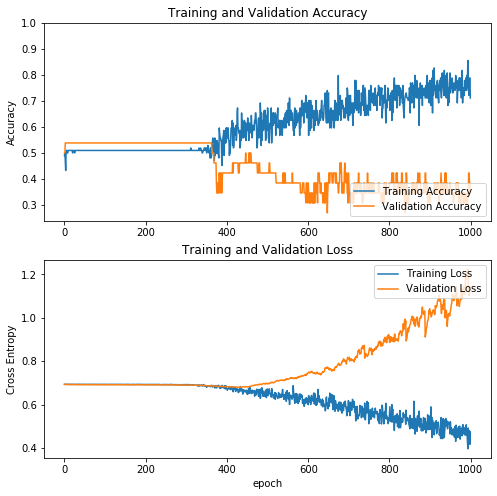

In [113]:
loss_name = "loss"
accuracy_name = "accuracy"

acc = model.history.history[accuracy_name]
val_acc = model.history.history[f'val_{accuracy_name}']

loss = model.history.history[loss_name]
val_loss = model.history.history[f"val_{loss_name}"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [114]:
np.round(model.predict([X_train]))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [118]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(model, X, y):
    
    cm1 = confusion_matrix(y, np.round(model.predict(X)))
    
    # total1 = sum(sum(cm1))
    
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    return sensitivity1, specificity1

In [120]:
cm1 = confusion_matrix(y_test[:,0], np.round(model.predict([X_test]))[:,0])

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print(sensitivity1, specificity1)

0.42857142857142855 0.25


In [121]:
cm1

array([[6, 8],
       [9, 3]])

In [97]:
real_names = []
for subject, label in zip(subjects, labels):
    if subject == "RE_ATTILIO":
        continue
    if not sequence_repo.has(subject, "FLAIR"):
        continue
    if not sequence_repo.has(subject, "MPRAGE"):
        continue
    if not sequence_repo.has(subject, "T1"):
        continue
    tasks.append((sequence_repo, subject, sequence_names, label))
    real_names.append(subject)


In [101]:
for s, l, c in zip(real_names, y, to_categorical(np.array(y))):
    print(s, l, c)

ALESSANDRINI_GLAUCO 0.0 [1. 0.]
ANGELONI_GIUSEPPINA 1.0 [0. 1.]
ASSANTO_MARIA 0.0 [1. 0.]
BAGNOLI_VINCENZO 1.0 [0. 1.]
BARONTINI_MARIA_GIOVANNA 0.0 [1. 0.]
BATTISTA_DOMENICA 1.0 [0. 1.]
BERGNACH_SILVANO 1.0 [0. 1.]
BERNOLA_TERESA 0.0 [1. 0.]
BERTUZZI_LUISA 0.0 [1. 0.]
BEVILACQUA_RITA 0.0 [1. 0.]
BIANCHI_GIOVANNI 0.0 [1. 0.]
BIANCHI_ORAZIO 0.0 [1. 0.]
BIAVATI_S 0.0 [1. 0.]
BOEZI_MARIO 1.0 [0. 1.]
BOVE_A 0.0 [1. 0.]
CACACE_PAOLO 1.0 [0. 1.]
CALDARONI_ANNA 1.0 [0. 1.]
CAMACCI_FILIBERTO 0.0 [1. 0.]
CAMPLESE_CANDEROLA 1.0 [0. 1.]
CAPEZZONE 0.0 [1. 0.]
CARULLI_L 1.0 [0. 1.]
CARZEDDA_PAOLO 0.0 [1. 0.]
CATALANI_F 0.0 [1. 0.]
CIMPUREANU_N 1.0 [0. 1.]
COLAFRANCESCO_ROCCO 0.0 [1. 0.]
COLAZZO_LUIGI_GIUSEPPE 0.0 [1. 0.]
COSTANZI_P 1.0 [0. 1.]
CRESCENZI_ARMANDO 0.0 [1. 0.]
DARIDA 0.0 [1. 0.]
DEL_BOVE_PIERINA 1.0 [0. 1.]
DE_PAOLI_R 1.0 [0. 1.]
DE_SANTIS_GIORGO 0.0 [1. 0.]
DIASPRO_G 1.0 [0. 1.]
DI_CARLATONIO_MAURIZIO 0.0 [1. 0.]
DI_LORENZO_TOMMASO 0.0 [1. 0.]
DI_MARCO_L 0.0 [1. 0.]
DI_MASO_SIMONE 0.0 